# Load data

<https://www.kaggle.com/c/bike-sharing-demand>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

import sage

In [2]:
# Load data
df = sage.datasets.bike()
feature_names = df.columns.tolist()[:-3]

In [3]:
# Split data, with total count serving as regression target
train, test = train_test_split(
    df.values, test_size=int(0.1 * len(df.values)), random_state=123
)
train, val = train_test_split(
    train, test_size=int(0.1 * len(df.values)), random_state=123
)
Y_train = train[:, -1].copy()
Y_val = val[:, -1].copy()
Y_test = test[:, -1].copy()
train = train[:, :-3].copy()
val = val[:, :-3].copy()
test = test[:, :-3].copy()

# Train model

In [4]:
import xgboost as xgb

In [5]:
# Set up data
dtrain = xgb.DMatrix(train, label=Y_train)
dval = xgb.DMatrix(val, label=Y_val)

# Parameters
param = {"max_depth": 10, "objective": "reg:squarederror", "nthread": 4}
evallist = [(dtrain, "train"), (dval, "val")]
num_round = 50

# Train
model = xgb.train(param, dtrain, num_round, evallist, verbose_eval=False)

In [6]:
# Calculate performance
mean = np.mean(Y_train)
base_mse = np.mean((mean - Y_test) ** 2)
mse = np.mean((model.predict(xgb.DMatrix(test)) - Y_test) ** 2)

print("Base rate MSE = {:.2f}".format(base_mse))
print("Model MSE = {:.2f}".format(mse))

Base rate MSE = 31591.23
Model MSE = 1920.86


# Permutation estimator

In [7]:
# Setup and calculate
imputer = sage.MarginalImputer(model, test[:512])
estimator = sage.PermutationEstimator(imputer, "mse")

# Run explainer multiple times
sage_list = []
for i in range(50):
    sage_list.append(
        estimator(
            test, Y_test, n_permutations=512 * 5, bar=False, detect_convergence=False
        )
    )

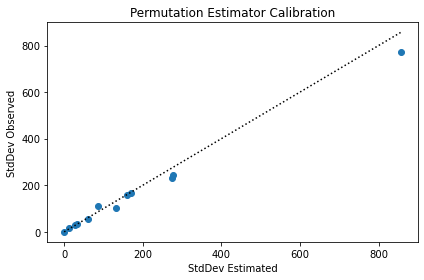

In [8]:
plt.figure()

# Scatter plot
std_est = sage_list[0].std
std_real = np.std(np.array([sage_values.values for sage_values in sage_list]), axis=0)
plt.scatter(std_est, std_real)

# Y = X line
m = max(std_est.max(), std_real.max())
plt.plot(
    [
        0,
        m,
    ],
    [0, m],
    color="black",
    linestyle=":",
)

plt.xlabel("StdDev Estimated")
plt.ylabel("StdDev Observed")
plt.title("Permutation Estimator Calibration")

plt.tight_layout()
plt.show()

# Permutation estimator (with efficiency relaxation)

In [9]:
# Setup and calculate
imputer = sage.MarginalImputer(model, test[:512])
estimator = sage.PermutationEstimator(imputer, "mse")

# Run explainer multiple times
sage_list = []
for i in range(50):
    sage_list.append(
        estimator(
            test,
            Y_test,
            n_permutations=512 * 5,
            bar=False,
            detect_convergence=False,
            min_coalition=3,
            max_coalition=9,
        )
    )

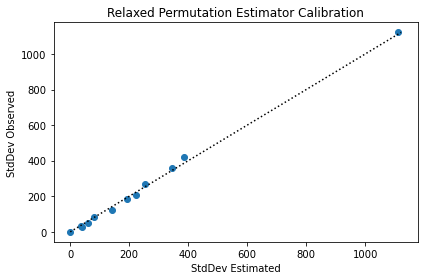

In [10]:
plt.figure()

# Scatter plot
std_est = sage_list[0].std
std_real = np.std(np.array([sage_values.values for sage_values in sage_list]), axis=0)
plt.scatter(std_est, std_real)

# Y = X line
m = max(std_est.max(), std_real.max())
plt.plot(
    [
        0,
        m,
    ],
    [0, m],
    color="black",
    linestyle=":",
)

plt.xlabel("StdDev Estimated")
plt.ylabel("StdDev Observed")
plt.title("Relaxed Permutation Estimator Calibration")

plt.tight_layout()
plt.show()

# Iterated estimator

In [11]:
# Setup and calculate
imputer = sage.MarginalImputer(model, test[:512])
estimator = sage.IteratedEstimator(imputer, "mse")

# Run explainer multiple times
sage_list = []
for i in range(50):
    sage_list.append(
        estimator(test, Y_test, n_samples=512, bar=False, detect_convergence=False)
    )

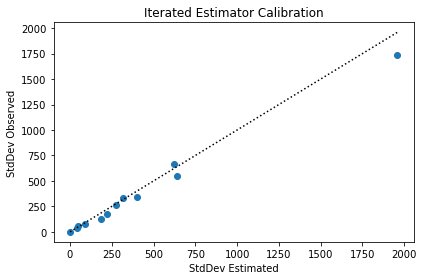

In [12]:
plt.figure()

# Scatter plot
std_est = sage_list[0].std
std_real = np.std(np.array([sage_values.values for sage_values in sage_list]), axis=0)
plt.scatter(std_est, std_real)

# Y = X line
m = max(std_est.max(), std_real.max())
plt.plot(
    [
        0,
        m,
    ],
    [0, m],
    color="black",
    linestyle=":",
)

plt.xlabel("StdDev Estimated")
plt.ylabel("StdDev Observed")
plt.title("Iterated Estimator Calibration")

plt.tight_layout()
plt.show()

# Kernel estimator

In [13]:
# Setup and calculate
imputer = sage.MarginalImputer(model, test[:512])
estimator = sage.KernelEstimator(imputer, "mse")

# Run explainer multiple times
sage_list = []
for i in range(50):
    sage_list.append(
        estimator(test, Y_test, n_samples=20000, bar=False, detect_convergence=False)
    )

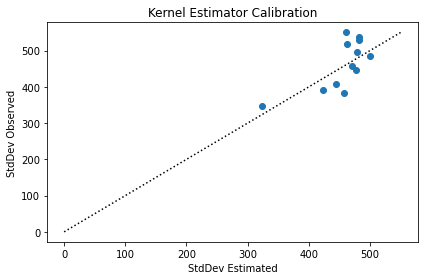

In [14]:
plt.figure()

# Scatter plot
std_est = sage_list[0].std
std_real = np.std(np.array([sage_values.values for sage_values in sage_list]), axis=0)
plt.scatter(std_est, std_real)

# Y = X line
m = max(std_est.max(), std_real.max())
plt.plot(
    [
        0,
        m,
    ],
    [0, m],
    color="black",
    linestyle=":",
)

plt.xlabel("StdDev Estimated")
plt.ylabel("StdDev Observed")
plt.title("Kernel Estimator Calibration")

plt.tight_layout()
plt.show()